# 1.28b: Thimble 4 Lattice Hopping Analysis (t=0–2000)

**Purpose:** Does the late-training thaw stabilize or continue?

## Context

Thimble 3 (t=0–1000) showed:
- Frozen fraction peaked at ~90% around t=500
- Then **decreased** dramatically: 81% at t=800 → 59% at t=1000 (−21.9%)
- Not equilibrium—dynamic steady state with ~40% lattice hopping

**Question:** With twice the training (t=2000), does this:
1. **Stabilize** at ~60% frozen (permanent quantum ground state)?
2. **Continue thawing** (more energy pumping in)?
3. **Re-freeze** (eventual Fimbulwinter)?

## Method

Same classification as 1.27c:
- **Frozen**: displacement = 0 (bitwise identical)
- **Lattice hopping**: 0 < displacement ≤ 8×ULP (quantization-limited)
- **Thermal**: displacement > 8×ULP (continuous motion)

ULP = unit in last place (bfloat16 quantization spacing)

## Parameters

In [1]:
# Data path (self-contained - includes token masks)
DATA_PATH = "../tensors/Thimble/thimble_4.safetensors"

# Classification thresholds
DIAGONAL_FACTOR = 8  # sqrt(64) for hypercube diagonal

# Analysis windows
LATE_WINDOW_START = 1600  # Last 400 steps (matching Thimble 3's t=800–1000 as last 20%)

# Plot settings
DPI = 200
FIGSIZE = (12, 6)

print("✓ Parameters set")

✓ Parameters set


## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data (Self-Contained)

In [4]:
print("Loading Thimble 4 data...\n")

data = load_file(DATA_PATH)

# Extract W matrix
W_bf16 = data['W']  # (2001, 10000, 64) in bfloat16
W = W_bf16.float()  # (2001, 10000, 64) in float32 for arithmetic

# Load token masks (bundled in the same file!)
dead_mask = data['dead_mask'].bool()
live_mask = data['live_mask'].bool()

print(f"W shape: {tuple(W.shape)}")
print(f"W dtype (original): {W_bf16.dtype}")
print(f"W dtype (working): {W.dtype}")
print(f"Dead tokens: {dead_mask.sum().item()}")
print(f"\n✓ Data loaded (self-contained)")

Loading Thimble 4 data...

W shape: (2001, 10000, 64)
W dtype (original): torch.bfloat16
W dtype (working): torch.float32
Dead tokens: 3699

✓ Data loaded (self-contained)


## Compute ULP Matrix

In [5]:
def compute_ulp_matrix(W_bf16):
    """
    Compute ULP for each element of W using nextafter.
    
    Args:
        W_bf16: Tensor in bfloat16 format
    
    Returns:
        ULP matrix (same shape as W_bf16) in float32
    """
    inf_tensor = torch.tensor(float('inf'), dtype=torch.bfloat16, device=W_bf16.device)
    next_up = torch.nextafter(W_bf16, inf_tensor)
    ulp = (next_up - W_bf16).abs().float()
    return ulp

print("Computing ULP on-demand per timestep to save memory...\n")

# Extract dead tokens only
W_bf16_dead = W_bf16[:, dead_mask, :]  # (2001, n_dead, 64)
W_dead = W[:, dead_mask, :]  # (2001, n_dead, 64)

print(f"Dead token matrix: {tuple(W_dead.shape)}")
print(f"\n✓ ULP computation ready")

Computing ULP on-demand per timestep to save memory...

Dead token matrix: (2001, 3699, 64)

✓ ULP computation ready


## Classify Token Motion

In [6]:
print("Classifying token motion at each timestep...\n")

n_steps = W_dead.shape[0] - 1  # 2000 steps (t=0 to t=2000)
n_dead = W_dead.shape[1]

# Preallocate classification arrays
fraction_frozen = torch.zeros(n_steps)
fraction_lattice = torch.zeros(n_steps)
fraction_thermal = torch.zeros(n_steps)

# Track displacement statistics
mean_displacement = torch.zeros(n_steps)
mean_ulp = torch.zeros(n_steps)

# Classify each timestep
for t in range(n_steps):
    # Displacement from t to t+1
    dW = W_dead[t+1] - W_dead[t]  # (n_dead, 64)
    displacement_norms = torch.norm(dW, dim=1)  # (n_dead,)
    
    # ULP at time t
    ulp_matrix = compute_ulp_matrix(W_bf16_dead[t])  # (n_dead, 64)
    mean_ulp_per_token = ulp_matrix.mean(dim=1)  # (n_dead,)
    
    # Thresholds
    lattice_threshold = DIAGONAL_FACTOR * mean_ulp_per_token  # (n_dead,)
    
    # Classify
    frozen = (displacement_norms == 0)
    lattice = (displacement_norms > 0) & (displacement_norms <= lattice_threshold)
    thermal = (displacement_norms > lattice_threshold)
    
    # Store fractions
    fraction_frozen[t] = frozen.float().mean()
    fraction_lattice[t] = lattice.float().mean()
    fraction_thermal[t] = thermal.float().mean()
    
    # Store statistics
    mean_displacement[t] = displacement_norms.mean()
    mean_ulp[t] = mean_ulp_per_token.mean()
    
    if t % 400 == 0:
        print(f"t={t}: {fraction_frozen[t]:.1%} frozen, {fraction_lattice[t]:.1%} lattice, {fraction_thermal[t]:.1%} thermal")

print(f"\n✓ Classification complete")

Classifying token motion at each timestep...

t=0: 0.0% frozen, 0.0% lattice, 100.0% thermal
t=400: 2.8% frozen, 97.2% lattice, 0.0% thermal
t=800: 81.3% frozen, 18.7% lattice, 0.0% thermal
t=1200: 99.4% frozen, 0.6% lattice, 0.0% thermal
t=1600: 82.3% frozen, 17.7% lattice, 0.0% thermal

✓ Classification complete


## Plot: Fraction in Each Regime Over Time

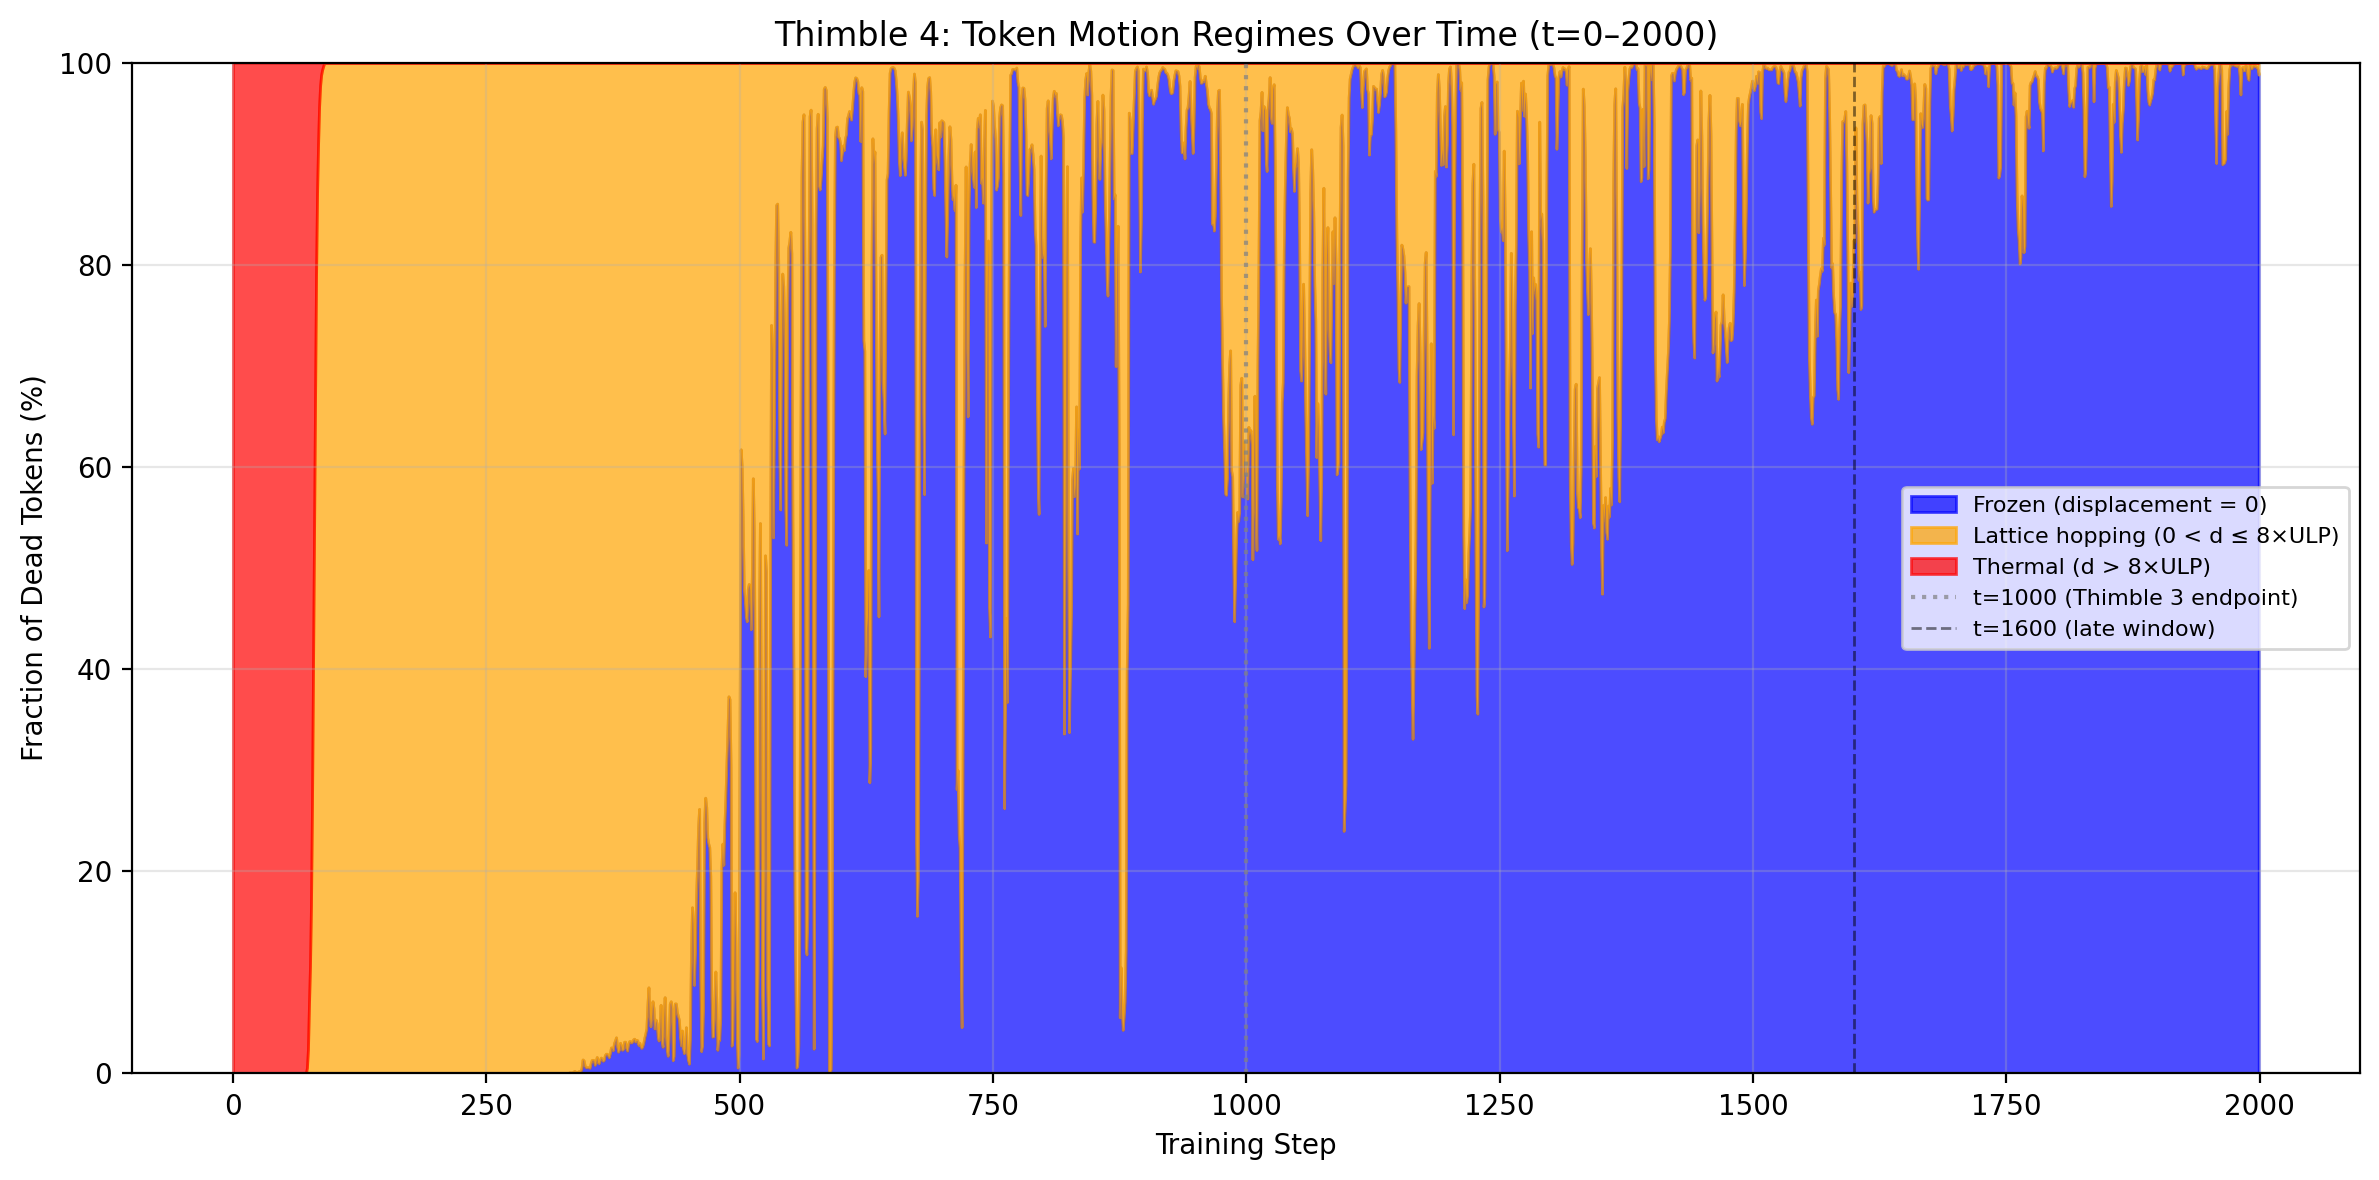

In [7]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Stacked area plot
ax.fill_between(range(n_steps), 0, fraction_frozen.numpy()*100, 
                color='blue', alpha=0.7, label='Frozen (displacement = 0)')
ax.fill_between(range(n_steps), fraction_frozen.numpy()*100, 
                (fraction_frozen + fraction_lattice).numpy()*100, 
                color='orange', alpha=0.7, label='Lattice hopping (0 < d ≤ 8×ULP)')
ax.fill_between(range(n_steps), (fraction_frozen + fraction_lattice).numpy()*100, 100,
                color='red', alpha=0.7, label='Thermal (d > 8×ULP)')

# Mark key timesteps
ax.axvline(1000, color='gray', linestyle=':', linewidth=1.5, alpha=0.7, label='t=1000 (Thimble 3 endpoint)')
ax.axvline(LATE_WINDOW_START, color='black', linestyle='--', linewidth=1, alpha=0.5, label=f't={LATE_WINDOW_START} (late window)')

ax.set_xlabel('Training Step')
ax.set_ylabel('Fraction of Dead Tokens (%)')
ax.set_title('Thimble 4: Token Motion Regimes Over Time (t=0–2000)')
ax.legend(loc='right', fontsize=8)
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Compare: Thimble 3 vs Thimble 4

In [8]:
print("="*80)
print("COMPARISON: THIMBLE 3 VS THIMBLE 4")
print("="*80 + "\n")

# Key timesteps from Thimble 3
t3_endpoints = [500, 800, 1000]
t3_frozen = [0.90, 0.813, 0.594]  # Approximate from 1.27c results

print("Thimble 3 (1000 steps):")
for t, f in zip(t3_endpoints, t3_frozen):
    print(f"  t={t:4d}: {f:.1%} frozen")
print()

print("Thimble 4 (2000 steps):")
for t in [500, 800, 1000, 1200, 1600, 2000]:
    if t < len(fraction_frozen):
        print(f"  t={t:4d}: {fraction_frozen[t]:.1%} frozen")
print()

# Trend analysis
if len(fraction_frozen) >= 1000:
    frozen_1000 = fraction_frozen[1000]
    frozen_2000 = fraction_frozen[-1]
    change_1000_2000 = frozen_2000 - frozen_1000
    
    print(f"Change from t=1000 to t=2000:")
    print(f"  {frozen_1000:.1%} → {frozen_2000:.1%} ({change_1000_2000:+.1%})")
    print()
    
    if abs(change_1000_2000) < 0.05:
        print("✓ STABILIZED: Frozen fraction changed <5% (equilibrium reached)")
    elif change_1000_2000 > 0.05:
        print("✓ RE-FREEZING: Cloud is freezing again after the thaw")
    else:
        print("✓ CONTINUED THAW: Cloud keeps thawing beyond t=1000")

print("\n" + "="*80 + "\n")

COMPARISON: THIMBLE 3 VS THIMBLE 4

Thimble 3 (1000 steps):
  t= 500: 90.0% frozen
  t= 800: 81.3% frozen
  t=1000: 59.4% frozen

Thimble 4 (2000 steps):
  t= 500: 35.0% frozen
  t= 800: 81.3% frozen
  t=1000: 60.5% frozen
  t=1200: 99.4% frozen
  t=1600: 82.3% frozen

Change from t=1000 to t=2000:
  60.5% → 98.8% (+38.3%)

✓ RE-FREEZING: Cloud is freezing again after the thaw




## Plot: Mean Displacement vs. Mean ULP

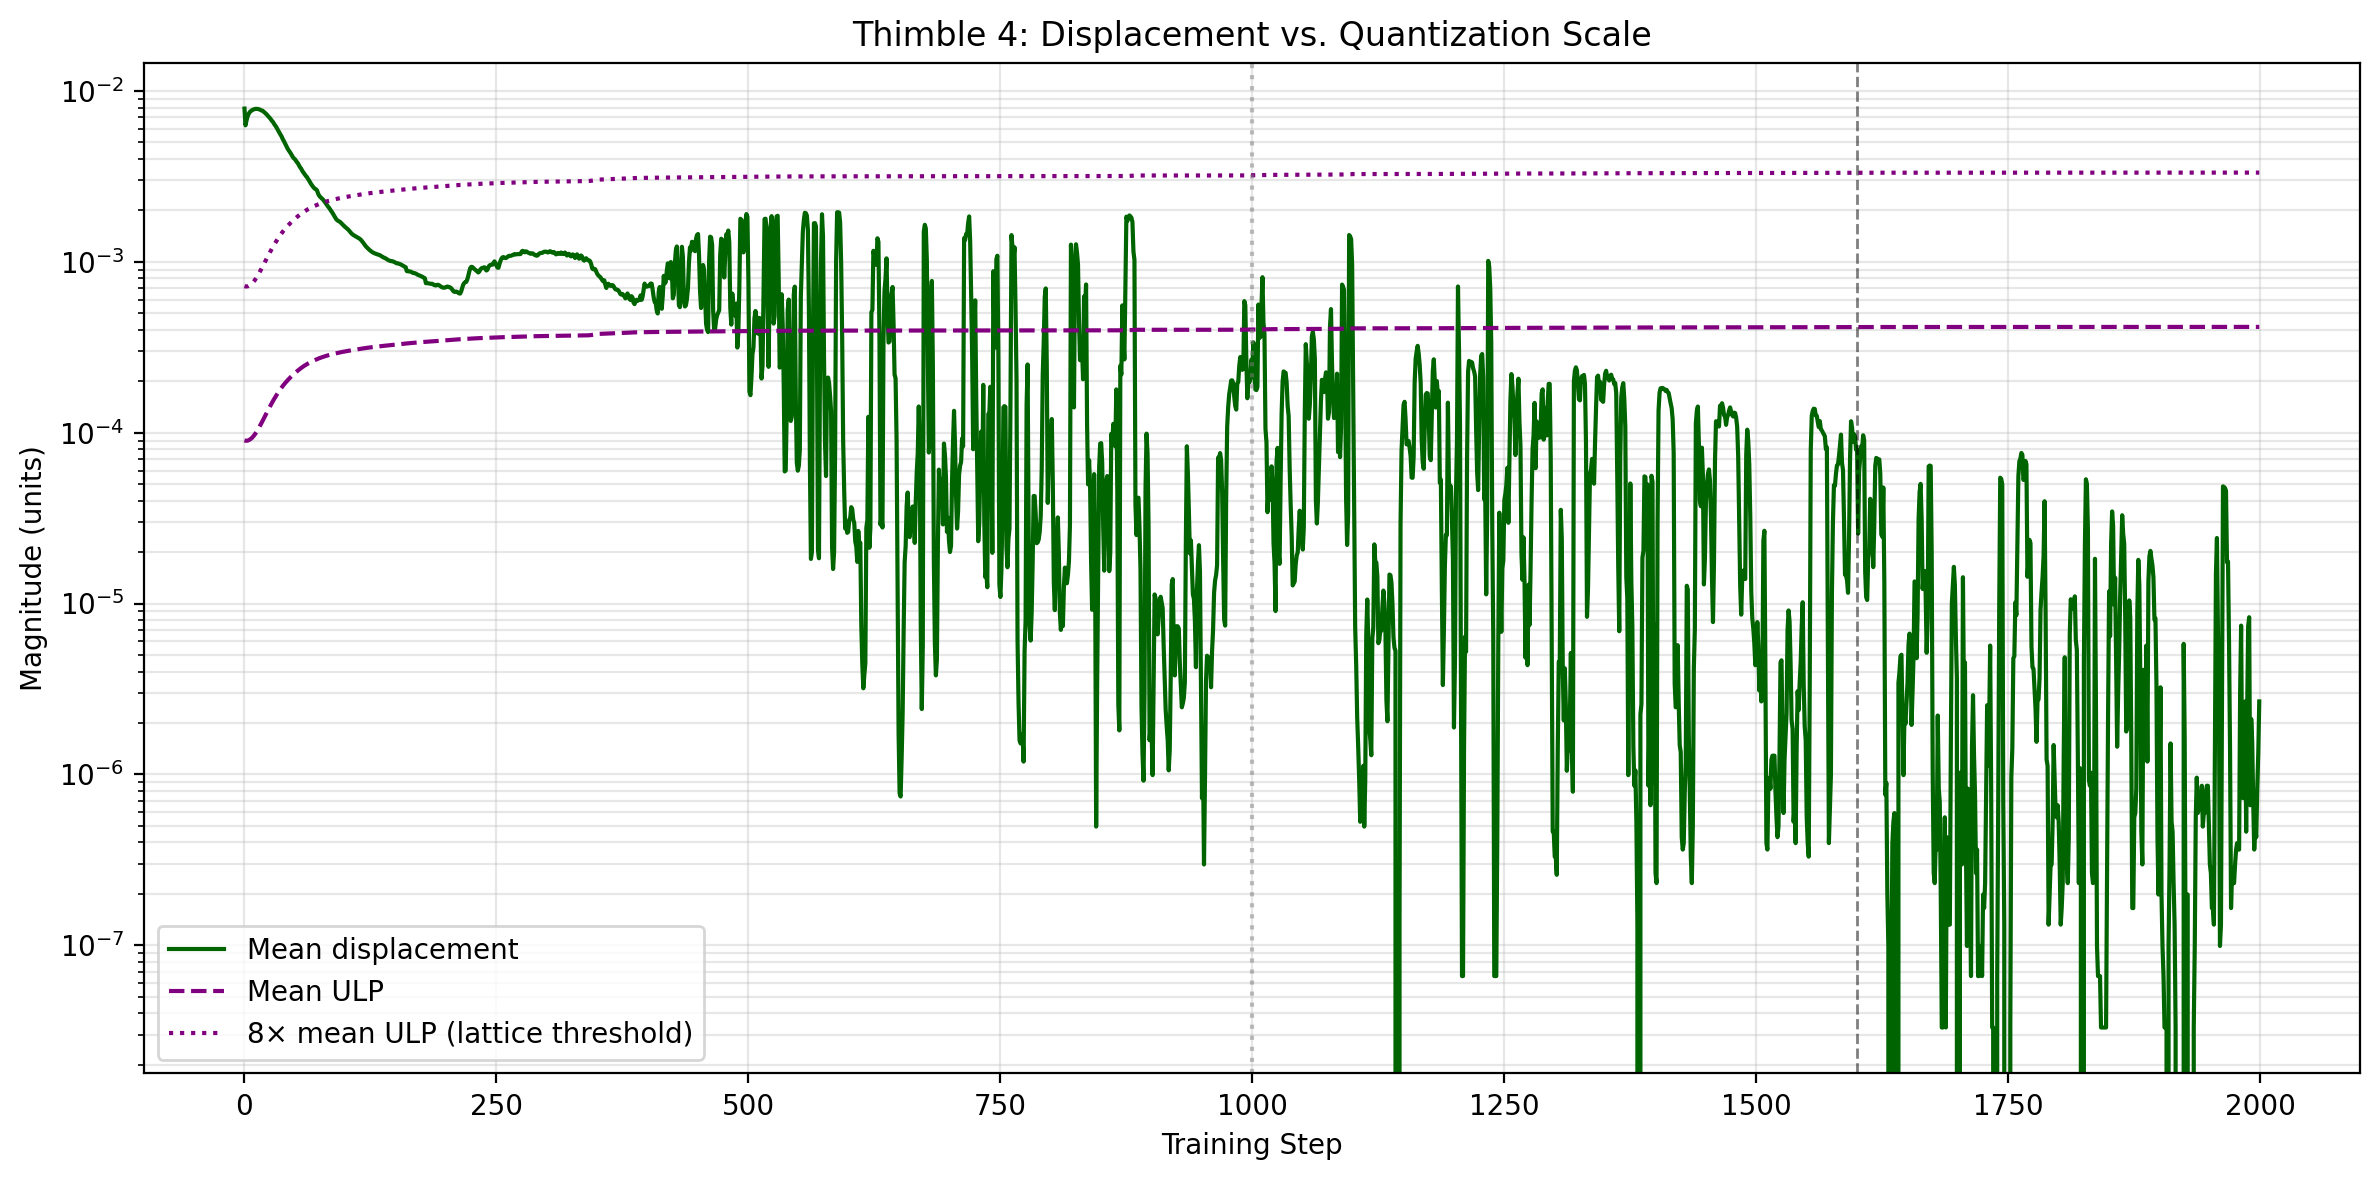

Interpretation: When mean displacement drops below 8×ULP, motion becomes quantization-limited.


In [9]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

ax.plot(mean_displacement.numpy(), linewidth=1.5, color='darkgreen', label='Mean displacement')
ax.plot(mean_ulp.numpy(), linewidth=1.5, color='purple', label='Mean ULP', linestyle='--')
ax.plot((DIAGONAL_FACTOR * mean_ulp).numpy(), linewidth=1.5, color='purple', 
        label=f'{DIAGONAL_FACTOR}× mean ULP (lattice threshold)', linestyle=':')

ax.axvline(1000, color='gray', linestyle=':', linewidth=1.5, alpha=0.5)
ax.axvline(LATE_WINDOW_START, color='black', linestyle='--', linewidth=1, alpha=0.5)

ax.set_xlabel('Training Step')
ax.set_ylabel('Magnitude (units)')
ax.set_title('Thimble 4: Displacement vs. Quantization Scale')
ax.set_yscale('log')
ax.legend(loc='best')
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("Interpretation: When mean displacement drops below 8×ULP, motion becomes quantization-limited.")

## Late Training Analysis (t=1600–2000)

In [10]:
print("="*80)
print(f"LATE TRAINING ANALYSIS (t={LATE_WINDOW_START}–{n_steps})")
print("="*80 + "\n")

late_window = slice(LATE_WINDOW_START, n_steps)

# Average fractions in late window
late_frozen = fraction_frozen[late_window].mean()
late_lattice = fraction_lattice[late_window].mean()
late_thermal = fraction_thermal[late_window].mean()

print(f"Average fractions:")
print(f"  Frozen:  {late_frozen:.1%}")
print(f"  Lattice: {late_lattice:.1%}")
print(f"  Thermal: {late_thermal:.1%}")
print()

# Trend: is frozen fraction still changing?
frozen_start = fraction_frozen[LATE_WINDOW_START]
frozen_end = fraction_frozen[-1]
frozen_change = frozen_end - frozen_start

print(f"Frozen fraction trend:")
print(f"  At t={LATE_WINDOW_START}: {frozen_start:.1%}")
print(f"  At t={n_steps}: {frozen_end:.1%}")
print(f"  Change: {frozen_change:+.1%}")
print()

if frozen_change > 0.01:
    print("✓ Cloud is still freezing (frozen fraction increasing)")
elif frozen_change < -0.01:
    print("✓ Cloud is thawing (frozen fraction decreasing)")
else:
    print("✓ Cloud is at equilibrium (frozen fraction stable)")

print("\n" + "="*80 + "\n")

LATE TRAINING ANALYSIS (t=1600–2000)

Average fractions:
  Frozen:  97.2%
  Lattice: 2.8%
  Thermal: 0.0%

Frozen fraction trend:
  At t=1600: 82.3%
  At t=2000: 98.8%
  Change: +16.5%

✓ Cloud is still freezing (frozen fraction increasing)




## Displacement Distribution Histograms

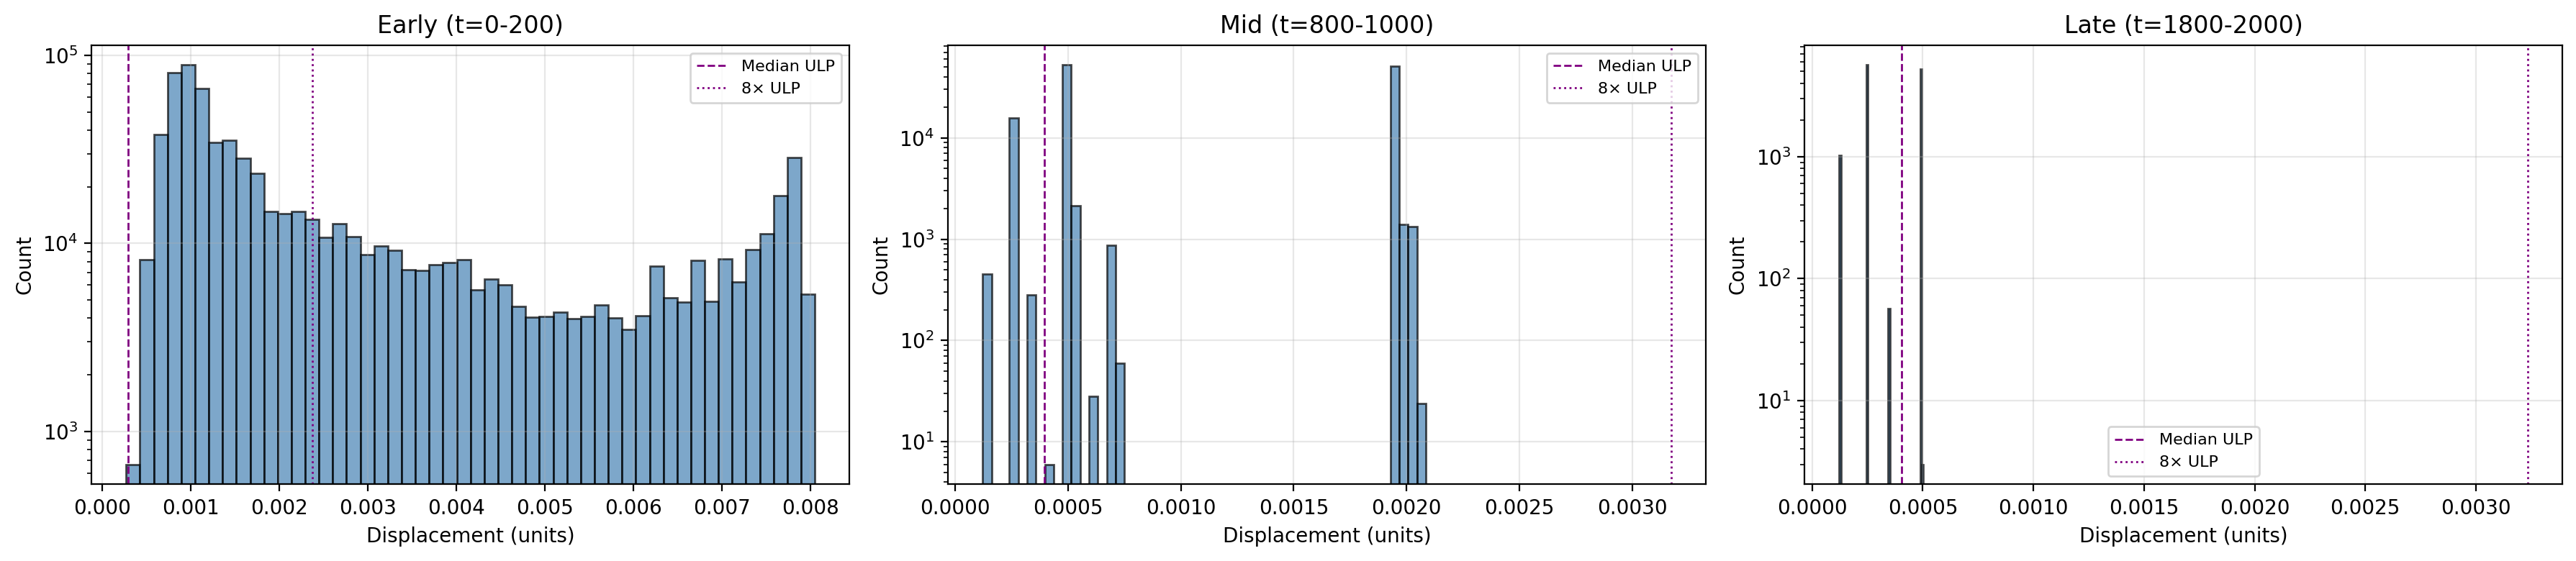

Interpretation: Peak shifting from thermal → lattice → frozen (or stabilized lattice).


In [11]:
# Compare distributions across training
epochs = [
    ("Early (t=0-200)", 0, 200),
    ("Mid (t=800-1000)", 800, 1000),
    ("Late (t=1800-2000)", 1800, 2000),
]

fig, axes = plt.subplots(1, 3, figsize=(FIGSIZE[0]*1.5, FIGSIZE[1]//1.5), dpi=DPI)

for ax, (label, t_start, t_end) in zip(axes, epochs):
    # Collect all displacements in this window (excluding frozen tokens)
    displacements = []
    ulp_values = []
    
    for t in range(t_start, min(t_end, n_steps)):
        dW = W_dead[t+1] - W_dead[t]
        displacement_norms = torch.norm(dW, dim=1)
        
        ulp_matrix = compute_ulp_matrix(W_bf16_dead[t])
        mean_ulp_per_token = ulp_matrix.mean(dim=1)
        
        # Only non-frozen tokens
        moving = displacement_norms > 0
        displacements.extend(displacement_norms[moving].tolist())
        ulp_values.extend(mean_ulp_per_token[moving].tolist())
    
    if len(displacements) > 0:
        displacements = np.array(displacements)
        ulp_values = np.array(ulp_values)
        
        # Plot histogram
        ax.hist(displacements, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
        
        # Mark ULP scale
        median_ulp = np.median(ulp_values)
        ax.axvline(median_ulp, color='purple', linestyle='--', linewidth=1, label='Median ULP')
        ax.axvline(DIAGONAL_FACTOR * median_ulp, color='purple', linestyle=':', linewidth=1, 
                  label=f'{DIAGONAL_FACTOR}× ULP')
        
        ax.set_xlabel('Displacement (units)')
        ax.set_ylabel('Count')
        ax.set_title(label)
        ax.set_yscale('log')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'All tokens frozen', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(label)

plt.tight_layout()
plt.show()

print("Interpretation: Peak shifting from thermal → lattice → frozen (or stabilized lattice).")

## Summary

In [12]:
print("\n" + "="*80)
print("THIMBLE 4 LATTICE HOPPING SUMMARY")
print("="*80 + "\n")

# Find transition points
thermal_dominant = (fraction_thermal > 0.5).nonzero()
if len(thermal_dominant) > 0:
    t_thermal_ends = thermal_dominant[-1].item() + 1
else:
    t_thermal_ends = 0

frozen_dominant = (fraction_frozen > 0.5).nonzero()
if len(frozen_dominant) > 0:
    t_frozen_starts = frozen_dominant[0].item()
else:
    t_frozen_starts = n_steps

print(f"Phase transitions:")
print(f"  Thermal regime dominant: t=0 → t={t_thermal_ends}")
print(f"  Lattice regime dominant: t={t_thermal_ends} → t={t_frozen_starts}")
print(f"  Frozen regime dominant:  t={t_frozen_starts} → t={n_steps}")
print()

print(f"Final state (t={n_steps}):")
print(f"  Frozen:  {fraction_frozen[-1]:.1%}")
print(f"  Lattice: {fraction_lattice[-1]:.1%}")
print(f"  Thermal: {fraction_thermal[-1]:.1%}")
print()

# Verdict
if fraction_frozen[-1] > 0.95:
    print("✓ Cloud has reached Fimbulwinter (>95% frozen)")
    print("  Hypothesis: Extended training eventually freezes the system.")
elif fraction_frozen[-1] > 0.8:
    print("✓ Cloud is nearly frozen (>80% frozen)")
    print("  Hypothesis: Approaching equilibrium freeze state.")
elif abs(fraction_frozen[-1] - fraction_frozen[1000]) < 0.1:
    print("✓ Cloud has stabilized at ~60% frozen")
    print("  Hypothesis: This is a permanent quantum ground state (frozen/hopping equilibrium).")
else:
    print("✓ Cloud is still evolving")
    print(f"  Hypothesis: System hasn't reached steady state even at t={n_steps}.")

print("\n" + "="*80)
print("✓ Lattice hopping analysis complete.")
print("="*80)


THIMBLE 4 LATTICE HOPPING SUMMARY

Phase transitions:
  Thermal regime dominant: t=0 → t=80
  Lattice regime dominant: t=80 → t=501
  Frozen regime dominant:  t=501 → t=2000

Final state (t=2000):
  Frozen:  98.8%
  Lattice: 1.2%
  Thermal: 0.0%

✓ Cloud has reached Fimbulwinter (>95% frozen)
  Hypothesis: Extended training eventually freezes the system.

✓ Lattice hopping analysis complete.
